This notebook is for plotting CPU details for an entity. It depends on ``hourly_agg_util.py`` and therefore the path to ``hourly_agg_util.py`` should be added to PYTHONPATH on the system where this notebook is imported. Also while starting pyspark, ``hourly_agg_util.py`` should be passed using the ``--py-files`` flag.

#### Using the notebook

The primary function here is ``call()``. Call this function with the following arguments:
- name of the hourly aggregation HDFS file
- name of the entity which is to be plotted
- A tuple denoting what values are to be plotted. Valid values that can be in the tuple are
    - "idle"
    - "iowait"
    - "system"
    - "user"
    - "nice"
  These values are case-insensitive

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import min as pymin
from pyspark.sql.functions import max as pymax

import hourly_agg_util as util

In [2]:
%matplotlib inline

In [3]:
def convert_timestamp_to_date_hr(ts):
    """
    Converts the given timestamp into string DD-MM-YYYY HH
    :param ts: The timestamp in SECONDS
    """
    return datetime.datetime(*time.gmtime(int(ts))[:6]).strftime("%d-%m-%Y %H")


def plot_cpu(data, num_hours, min_tstamp, plot_details=("idle", "iowait", "system", "idle")):
    """
    Plot a graph of CPU utilization for a given data
    :param data: A dictionary with hour num (with 0 for first hour in data) as key
                 and (idle, user, system, iowait) as value
    :param num_hours: The number of hours in the entire data
    :param min_tstamp: The minimum time stamp (marking the beginning of data)
    :param plot_details: An iterable containing names of things to plot. The names are
                         "idle": Plot PercIdle
                         "iowait": Plot PercIOWait
                         "system": Plot PercSystem
                         "user": Plot PercUser
                         "nice": Plot PercNice
                         These names are case-insensitive
    """
    plot_details = [x.lower() for x in plot_details]
    idle = []
    system = []
    user = []
    iowait = []
    nice = []
    for h in xrange(0, num_hours + 1):
        vals = data.get(h, (np.nan, np.nan, np.nan, np.nan, np.nan))
        idle.append(vals[0])
        system.append(vals[1])
        user.append(vals[2])
        iowait.append(vals[3])
        nice.append(vals[4])
    xaxis2 = np.arange(num_hours+1)
    fig = plt.figure(1, figsize = (12, 10))
    plt.xticks(rotation='vertical')
    legends = []
    if "idle" in plot_details:
        plt.plot(xaxis2, idle)
        legends.append("Idle")
    if "system" in plot_details:
        plt.plot(xaxis2, system)
        legends.append("System")
    if "user" in plot_details:
        plt.plot(xaxis2, user)
        legends.append("User")
    if "iowait" in plot_details:
        plt.plot(xaxis2, iowait)
        legends.append("IOWait")
    if "nice" in plot_details:
        plt.plot(xaxis2, nice)
        legends.append("Nice")
    plt.gca().axis([0, num_hours+1, 0.0, 100.0])
    plt.legend(legends, loc='best', bbox_to_anchor=(1.2, 1.0))
    ax = plt.gca()
    a = ax.get_xticks().tolist()
    plt.gca().set_xticklabels([convert_timestamp_to_date_hr(min_tstamp + int(m)*3600) for m in a])
    ax.get_xaxis().set_tick_params(direction='out', width=1)
    ax.get_yaxis().set_tick_params(direction='out', width=1)
    plt.show()


def get_min_max(df):
    """
    Get minimum and maximum timestamp for data
    """
    min_max = df.select(pymin("group_interval_tstamp").alias("min_tstamp"), pymax("group_interval_tstamp").alias("max_tstamp")).collect()
    min_tstamp = min_max[0].min_tstamp
    max_tstamp = min_max[0].max_tstamp
    num_hours = (max_tstamp - min_tstamp)/3600
    return min_tstamp, max_tstamp, num_hours    


def get_plot_data(df, entity, min_tstamp):
    # find data for entity we are interested in
    df2 = df.filter("entity='{0}'".format(entity)).select("group_interval", "group_interval_tstamp", "avg_PercIdle", "avg_PercSystem", "avg_PercUser", "avg_PercIOWait", "avg_PercNice").orderBy("group_interval_tstamp")
    rs = df2.collect()
    # Now assing index numbers
    res = dict([(((x.group_interval_tstamp - min_tstamp)/3600),(x.avg_PercIdle, x.avg_PercSystem, x.avg_PercUser, x.avg_PercIOWait, x.avg_PercNice)) for x in rs])
    return res


def call(filename, entity, plot_details=("idle", "iowait", "system", "user", "nice")):
    df = sqlContext.read.json(filename)
    df = util.clean_data_for_hour(df, 4)
    df = util.augment_group_interval(df)
    do(df, entity, plot_details)


def do(df, entity, plot_details):
    min_tstamp, max_tstamp, num_hours = get_min_max(df)
    res = get_plot_data(df, entity, min_tstamp)
    plot_cpu(res, num_hours, min_tstamp, plot_details=plot_details)

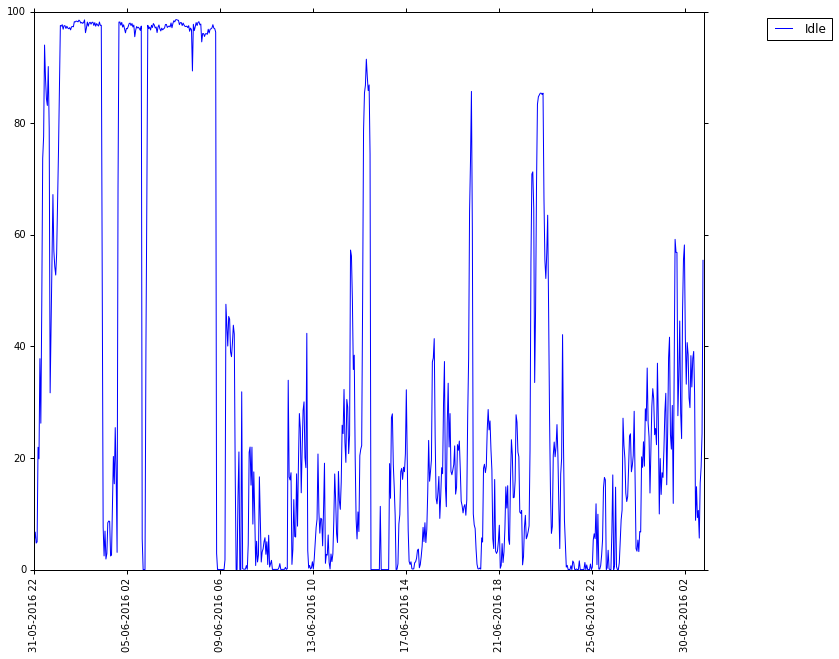

In [7]:
call("lemon_aggregates/bi/2016_06/hourly_13184", "b6f25e0a42", ("idle",))

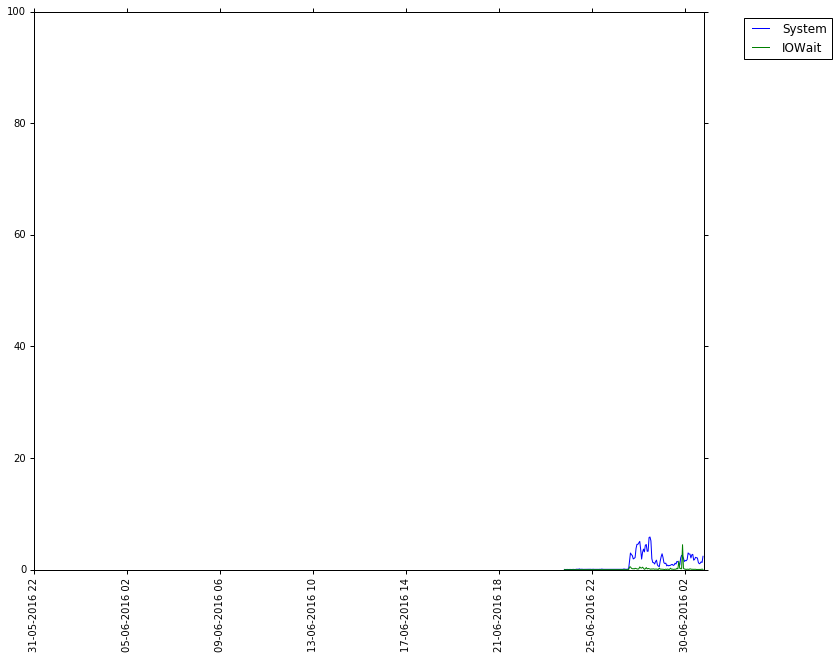

In [4]:
call("lemon_aggregates/bi/2016_06/hourly_13184", "b6cb338269", plot_details=("iowait", "system"))

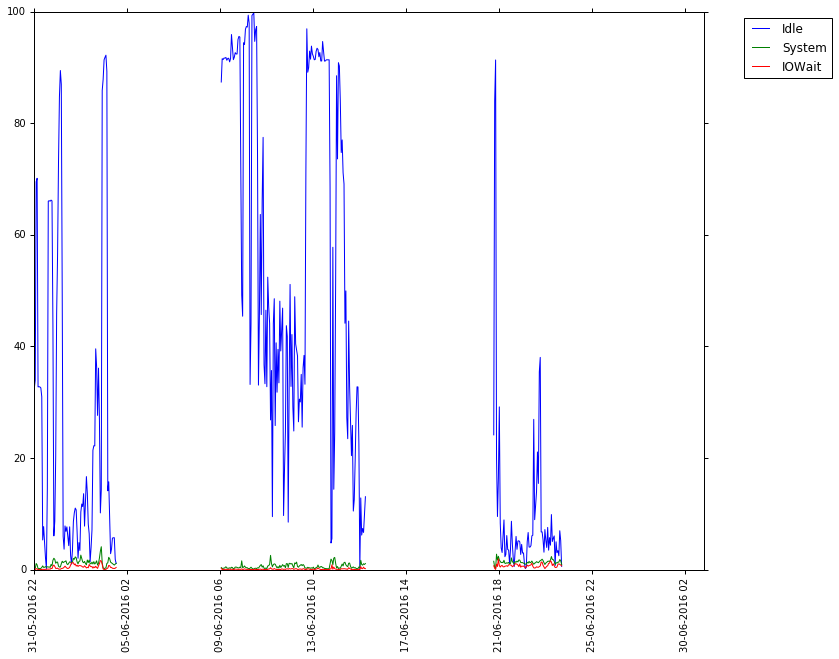

In [5]:
call("lemon_aggregates/bi/2016_06/hourly_13184", "b6bdbe995f", plot_details=("iowait", "system", "idle"))